<a href="https://colab.research.google.com/github/a-m-kacz/MLA/blob/main/report_mnist_in_3_flavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of handwritten digits using various neural network models with PyTorch
* Multinomial classification task of images of handwritten digits (10 classes).
* The database has a training set of 60k examples, and a test set of 10k examples, each image is of 28x28 pixels size.
* The MNIST ("Modified National Institute of Standards and Technology") is the “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

## Model setup

Before we start we need to load libraries and setup the model parameters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 50
# logging frequency
model_args['log_interval'] = 100

Let's start with loading the dataset and check how it looks like
> **In case of problems with downloading dataset via torchvison please use the second method**

In [2]:
# load the MINST dataset via torchvision 
transform = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Second method: directly download tar.gz archive

In [3]:
# alternatively just download MNIST.tar.gz archive
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

transform = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./', train=True, download=False, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('./', train=False, download=False, transform=transform)

--2023-03-20 15:59:50--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-03-20 15:59:51--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [             <=>    ]  33.20M  8.29MB/s    in 4.9s    

2023-03-20 15:59:57 (6.75 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [4]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

Plot sample images

50000
10000
10000
391
torch.Size([28, 28])


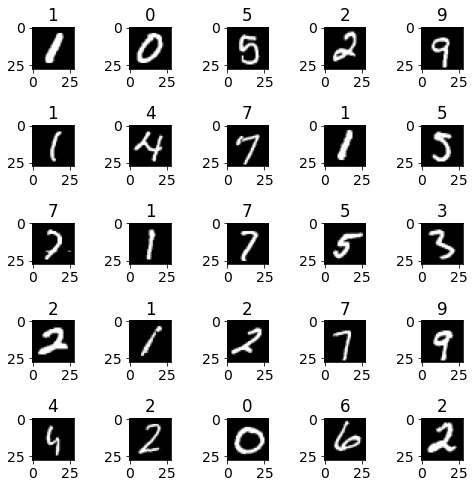

In [5]:
print(len(train_subset))
print(len(validation_subset))
print(len(test_subset)) # we have data already divided into train & validation & test subsets
print(len(train_loader)) # no of train batches
example_number = 123
print(train_subset[example_number][0][0].shape) # single item shape

fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

Let's now construct the NN models:
- we start with siplest single layer **perceptron** with *softmax* activation,
- then test **deep** network with some (fully-connected) *hidden* layers,
- and finally setup deep **convolutional neural network**.

In [6]:
class Perceptron(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Perceptron, self).__init__()
        # fully connected layer
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        # hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class CNN(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5) 
        # 8 kernels of size 5x5
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        # 2D dropout
        self.conv2_drop = nn.Dropout2d()
        # fully connected layers
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 2 feature maps each of size 24x24
        x = F.max_pool2d(x, 2) # downsizing each map to 12x12
        x = F.relu(x) # standard (in CNNs) ReLU activation
        # 2nd group
        x = self.conv2(x) # resulting in 4 feature maps each of size 8x8
        # x = self.conv2_drop(x) 
        x = F.max_pool2d(x, 2) # downsizing each map to 4x4
        x = F.relu(x)
        # fully connected layers
        x = x.view(-1, 64) # 4 maps of 4x4 size gives 64 numbers
        x = self.fc1(x) # 64 -> 20
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # dropout is a type of regularization
        x = self.fc2(x) # 20 -> 10
        # softmax (multinomial classification) gives probabilities of each class
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch


In [7]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


And define training, testing, and plotting utils:

In [8]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss.cpu()

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

## Experiments

1. At first let's test the single-layer *Perceptron* model



Train Epoch: 1 [0/50000 (0%)]	Loss: 2.483149
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.307843
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.291153
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.224341

Train set: Average loss: 0.3778
Validation set: Average loss: 0.3002, Accuracy: 9130/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.230951
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.285204
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.361045
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.275906

Train set: Average loss: 0.3039
Validation set: Average loss: 0.2911, Accuracy: 9188/10000 (92%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.225105
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.300123
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.306779
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.267768

Train set: Average loss: 0.2913
Validation set: Average loss: 0.2944, Accuracy: 9166/10000 (92%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.304264
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.226859
Train Epoch: 4 [25600/5

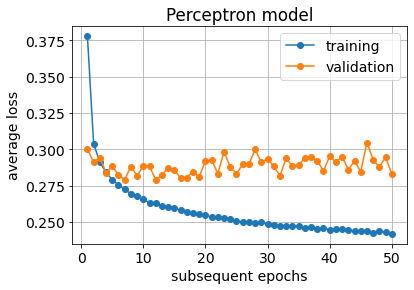

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_perceptron = Perceptron().to(device)

optimizer = optim.SGD(model_perceptron.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss_perceptron = []
validation_loss_perceptron = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss_perceptron.append(train(model_perceptron, device, train_loader, optimizer, epoch_number))
    validation_loss_perceptron.append(test(model_perceptron, device, validation_loader, 'Validation set'))

test(model_perceptron, device, test_loader, 'Test set')
plot_loss(train_loss_perceptron, validation_loss_perceptron, 'Perceptron model')

2. Now add a hidden layer to the *Perceptron* and evaluate the *Deep* model 

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.337307
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.297851
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.304081
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.201663

Train set: Average loss: 0.4089
Validation set: Average loss: 0.2629, Accuracy: 9253/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.198535
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.190634
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.251895
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.195246

Train set: Average loss: 0.2431
Validation set: Average loss: 0.2164, Accuracy: 9402/10000 (94%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.199858
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.221355
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.197546
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.149986

Train set: Average loss: 0.2010
Validation set: Average loss: 0.1973, Accuracy: 9441/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.245581
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.142844
Train Epoch: 4 [25600/5

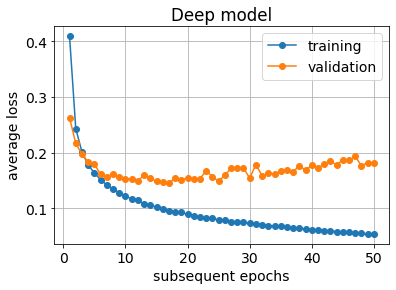

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_deep = Deep().to(device)

optimizer = optim.SGD(model_deep.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss_deep = []
validation_loss_deep = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss_deep.append(train(model_deep, device, train_loader, optimizer, epoch_number))
    validation_loss_deep.append(test(model_deep, device, validation_loader, 'Validation set'))

test(model_deep, device, test_loader, 'Test set')
plot_loss(train_loss_deep, validation_loss_deep, 'Deep model')

3. Compare these results with a deep convolutional network, which is more useful in real-world problems:

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.322561
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.365280
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.160825
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.848410

Train set: Average loss: 1.1838
Validation set: Average loss: 0.3490, Accuracy: 8883/10000 (89%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.721737
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.585873
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.888476
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.607902

Train set: Average loss: 0.6692
Validation set: Average loss: 0.1964, Accuracy: 9404/10000 (94%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.400005
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.510131
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.487941
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.624299

Train set: Average loss: 0.5715
Validation set: Average loss: 0.1926, Accuracy: 9411/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.643843
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.543449
Train Epoch: 4 [25600/5

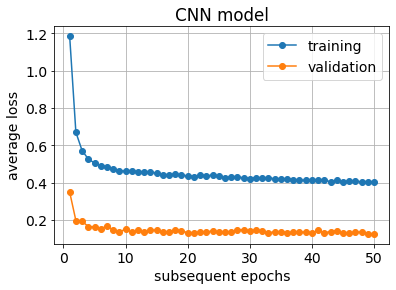

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cnn = CNN().to(device)

optimizer = optim.SGD(model_cnn.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss_cnn = []
validation_loss_cnn = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss_cnn.append(train(model_cnn, device, train_loader, optimizer, epoch_number))
    validation_loss_cnn.append(test(model_cnn, device, validation_loader, 'Validation set'))

test(model_cnn, device, test_loader, 'Test set')
plot_loss(train_loss_cnn, validation_loss_cnn, 'CNN model')

## Tasks to do
* apply some regularization technique to *Deep* model in order to avoid overfitting (start with nonzero *weight_decay* in optimizer)



Train Epoch: 1 [0/50000 (0%)]	Loss: 2.335031
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.313030
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.295369
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.204881

Train set: Average loss: 0.4191
Validation set: Average loss: 0.2632, Accuracy: 9229/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.197673
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.218419
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.270306
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.251739

Train set: Average loss: 0.2537
Validation set: Average loss: 0.2267, Accuracy: 9335/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.158677
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.209050
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.200105
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.163221

Train set: Average loss: 0.2131
Validation set: Average loss: 0.2084, Accuracy: 9408/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.202528
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.157068
Train Epoch: 4 [25600/5

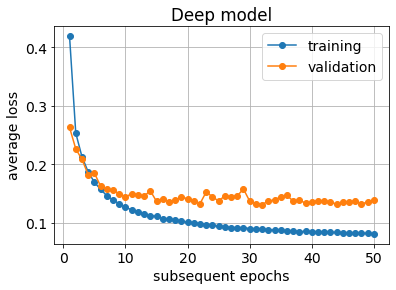

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_deep2 = Deep().to(device)

optimizer = optim.SGD(model_deep2.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=0.001)#1.e-3
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss_deep2 = []
validation_loss_deep2 = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss_deep2.append(train(model_deep2, device, train_loader, optimizer, epoch_number))
    validation_loss_deep2.append(test(model_deep2, device, validation_loader, 'Validation set'))


Default deep model calculated above vs deep model optimized with turned on weight_decay

Test set: Average loss: 0.1977, Accuracy: 9543/10000 (95%)



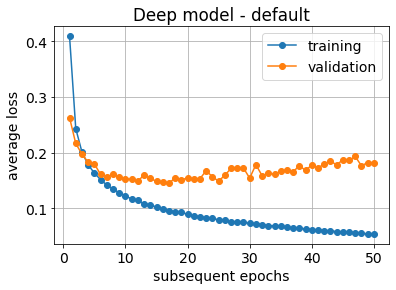

In [36]:
test(model_deep, device, test_loader, 'Test set')
plot_loss(train_loss_deep, validation_loss_deep, 'Deep model - default')

Test set: Average loss: 0.1319, Accuracy: 9619/10000 (96%)



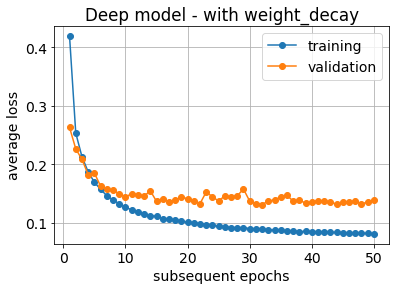

In [37]:
test(model_deep2, device, test_loader, 'Test set')
plot_loss(train_loss_deep2, validation_loss_deep2, 'Deep model - with weight_decay')

* try to figure out why the validation loss for *CNN* model turns to be *lower* than the train loss (hint: turn off regularization),

Dropout is a form of regularization and on validation set it is not included.


Using fropout we train in fact different smaller models but on validation we use full model that has bigger capacity, so the problem with this plot is that we compare different models on different sets.

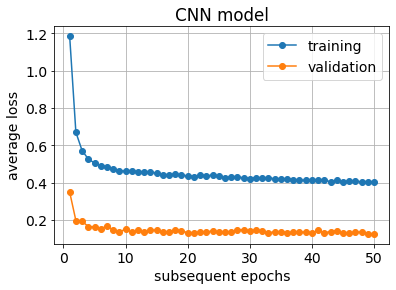

In [38]:
plot_loss(train_loss_cnn, validation_loss_cnn, 'CNN model')

default plot calculated above and second one with turned off

* **tune one of these models to get the *Test Set Accuracy* > 99%**,


In [39]:
class CNN_v2(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN_v2, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5) 
        # 20 kernels of size 5x5
        # 2D dropout
        self.conv2_drop = nn.Dropout2d()
        # fully connected layers
        self.fc1 = nn.Linear(720, 360)
        self.fc2 = nn.Linear(360, 180)
        self.fc3 = nn.Linear(180, 90)
        self.fc4 = nn.Linear(90, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 2 feature maps each of size 24x24
        x = F.max_pool2d(x, 2) # downsizing each map to 12x12
        x = F.max_pool2d(x, 2) # downsizing each map to 6x6
        x = F.relu(x) # standard (in CNNs) ReLU activation

        # fully connected layers
        x = x.view(-1, 720) # 20 maps of 6x6 size gives 64 numbers
        x = self.fc1(x) # 720 -> 360
        x = F.relu(x)
        x = self.fc2(x) # 360 -> 180
        x = F.relu(x)
        x = self.fc3(x) # 180- -> 90
        x = F.relu(x)
        x = self.fc4(x) # 90 -> 10

        # softmax (multinomial classification) gives probabilities of each class
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

In [40]:
from torchsummary import summary

model = CNN_v2()
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 24, 24]          520
├─Linear: 1-2                            [-1, 360]                 259,560
├─Linear: 1-3                            [-1, 180]                 64,980
├─Linear: 1-4                            [-1, 90]                  16,290
├─Linear: 1-5                            [-1, 10]                  910
Total params: 342,260
Trainable params: 342,260
Non-trainable params: 0
Total mult-adds (M): 0.63
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 1.31
Estimated Total Size (MB): 1.40


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 24, 24]          520
├─Linear: 1-2                            [-1, 360]                 259,560
├─Linear: 1-3                            [-1, 180]                 64,980
├─Linear: 1-4                            [-1, 90]                  16,290
├─Linear: 1-5                            [-1, 10]                  910
Total params: 342,260
Trainable params: 342,260
Non-trainable params: 0
Total mult-adds (M): 0.63
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 1.31
Estimated Total Size (MB): 1.40

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301099
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.789700
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.233661
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.109117

Train set: Average loss: 0.5679
Validation set: Average loss: 0.1296, Accuracy: 9587/10000 (96%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.058300
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.058665
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.080919
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.066534

Train set: Average loss: 0.0942
Validation set: Average loss: 0.0666, Accuracy: 9791/10000 (98%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.052059
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.086373
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.050783
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.012730

Train set: Average loss: 0.0650
Validation set: Average loss: 0.0709, Accuracy: 9769/10000 (98%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.125933
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.053678
Train Epoch: 4 [25600/5

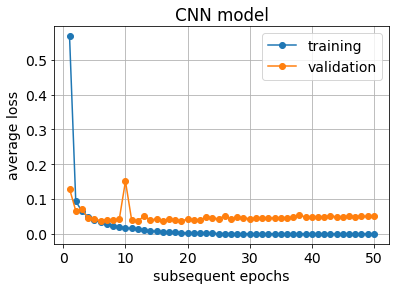

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cnnv2 = CNN_v2().to(device)

optimizer = optim.SGD(model_cnnv2.parameters(), lr=model_args['lr'], momentum=model_args['momentum'],nesterov=True)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss_cnnv2 = []
validation_loss_cnnv2 = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss_cnnv2.append(train(model_cnnv2, device, train_loader, optimizer, epoch_number))
    validation_loss_cnnv2.append(test(model_cnnv2, device, validation_loader, 'Validation set'))

test(model_cnnv2, device, test_loader, 'Test set')
plot_loss(train_loss_cnnv2, validation_loss_cnnv2, 'CNN model')

* plot the *confusion matrix* among all of the classes---which of digits are mostly confused with each other?

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusion_matrix(model,device,data_loader=test_loader):
  y_true = []
  y_pred = []
  
  with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device) 
              output = model(data)
              # get the index of class with the max log-probability 
              prediction = output.argmax(dim=1)   
              y_true.extend(target.cpu().numpy())
              y_pred.extend(prediction.cpu().numpy())

  cf_matrix = confusion_matrix(y_true, y_pred)
  class_names = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
 
  # Create pandas dataframe
  dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
  plt.figure(figsize=(8, 6))
 
  # Create heatmap
  sn.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
  
  plt.title("Confusion Matrix"), plt.tight_layout()
  
  plt.ylabel("True Class"), 
  plt.xlabel("Predicted Class")
  plt.show()

Test set - perceptron: Average loss: 0.2903, Accuracy: 9221/10000 (92%)



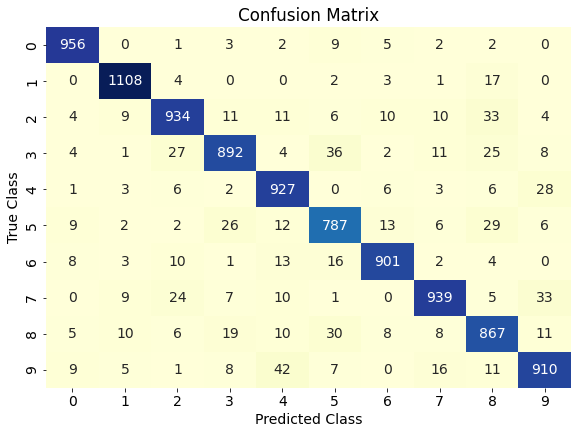

In [43]:
test(model_perceptron, device, test_loader, 'Test set - perceptron')
plot_confusion_matrix(model_perceptron,device)

Test set - deep: Average loss: 0.1993, Accuracy: 9543/10000 (95%)



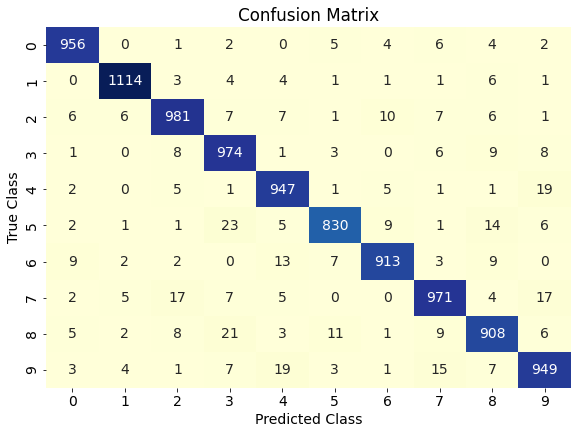

In [44]:
test(model_deep, device, test_loader, 'Test set - deep')
plot_confusion_matrix(model_deep,device)

Test set - deep2: Average loss: 0.1322, Accuracy: 9619/10000 (96%)



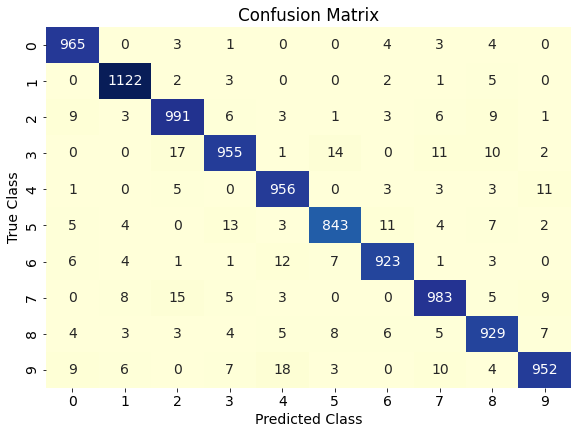

In [45]:
test(model_deep2, device, test_loader, 'Test set - deep2')
plot_confusion_matrix(model_deep2,device)

Test set - cnn: Average loss: 0.1219, Accuracy: 9670/10000 (97%)



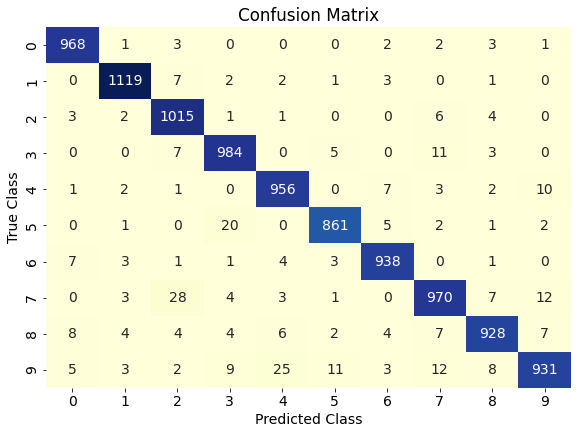

In [47]:
test(model_cnn, device, test_loader, 'Test set - cnn')
plot_confusion_matrix(model_cnn,device)

Test set - cnnv2: Average loss: 0.0434, Accuracy: 9912/10000 (99%)



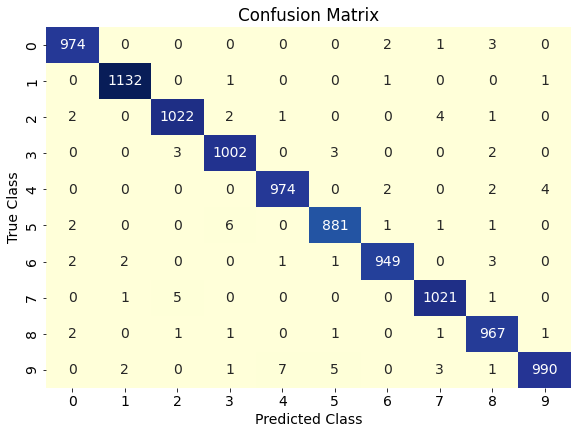

In [48]:
test(model_cnnv2, device, test_loader, 'Test set - cnnv2')
plot_confusion_matrix(model_cnnv2,device)